In [60]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import quail
import pickle
import scipy
from scipy.stats import pearsonr
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from itertools import groupby
from matplotlib.patches import Ellipse

<h2> Import Data </h2>

In [61]:
# transcription 
auto = quail.load_egg('../data/auto_egg.egg')
man = pickle.load(open('../data/ROC_manual_transcriptions.p', 'rb'))

# confidence scores
roc = pickle.load(open('../data/formattedforROC.p', 'rb'))

In [62]:
roc

[u'FOLLOWING IS DATA FOR debugMZNC0G:debugHH9F77',
 ([['Narcissus',
    'Arizona',
    'dress',
    'Montana',
    'Utah',
    'toaster',
    'nice',
    'girdle',
    'underwear',
    'Daisy',
    'sunflower',
    'download',
    'Maine']],
  [['0.849048554897',
    '0.889870762825',
    '0.768749892712',
    '0.891385734081',
    '0.875405490398',
    '0.811597287655',
    '0.909090936184',
    '0.848529279232',
    '0.804279625416',
    '0.809303343296',
    '0.801754236221',
    '0.521171867847',
    '0.899440169334']]),
 ([['giraffe',
    'horse',
    'cow',
    'Mouse',
    'window',
    'refrigerator',
    'glass',
    'spatula',
    'call',
    'corridor',
    'tangelo',
    'strawberry',
    'guava',
    'kiwi']],
  [['0.765662014484',
    '0.813870966434',
    '0.810189843178',
    '0.7642968297',
    '0.810104250908',
    '0.847153902054',
    '0.788434028625',
    '0.857377529144',
    '0.815360069275',
    '0.849401772022',
    '0.854677557945',
    '0.785321056843',
    '

<h2> Organize Automatic Transcription and Confidence Ratings </h2>

In [72]:
IDs = range(0, 510, 17)

subID=[]
conf_list = []
word_list = []

# for each sub, get subID
for item in roc:
    if roc.index(item) in IDs:
        subID.append(item[-23:])
        
    # list words and confs
    else:
        word_list.append(item[0][0])
        conf_list.append(item[1][0])
        
# nest lists
word = [word_list[i:i+8] for i in range(0,len(word_list), 8)]
conf = [conf_list[i:i+8] for i in range(0,len(conf_list), 8)]

In [73]:
# switch text to all caps to match manual transcriptions
new_transcription_ROC = []
for subject in word:
    new_subject = []
    for lst in subject:
        new_lst = []
        for word in lst:
            new_lst.append(word.upper())
        new_subject.append(new_lst)
    new_transcription_ROC.append(new_subject)
    
word = new_transcription_ROC

In [75]:
conf

[[['0.849048554897',
   '0.889870762825',
   '0.768749892712',
   '0.891385734081',
   '0.875405490398',
   '0.811597287655',
   '0.909090936184',
   '0.848529279232',
   '0.804279625416',
   '0.809303343296',
   '0.801754236221',
   '0.521171867847',
   '0.899440169334'],
  ['0.765662014484',
   '0.813870966434',
   '0.810189843178',
   '0.7642968297',
   '0.810104250908',
   '0.847153902054',
   '0.788434028625',
   '0.857377529144',
   '0.815360069275',
   '0.849401772022',
   '0.854677557945',
   '0.785321056843',
   '0.802003622055',
   '0.850266575813'],
  ['0.847521364689',
   '0.835472166538',
   '0.820234537125',
   '0.820234537125',
   '0.820234537125',
   '0.820234537125',
   '0.820234537125',
   '0.820234537125',
   '0.7903881073',
   '0.7903881073',
   '0.7903881073',
   '0.792592585087',
   '0.792592585087',
   '0.792592585087',
   '0.843339264393',
   '0.857475340366',
   '0.844499111176',
   '0.842200100422',
   '0.800746202469',
   '0.782299101353'],
  ['0.826115906239

In [76]:
# remove placeholder strings 
del word[1::2]
del conf[1::2]

In [85]:
len(conf[0])

8

<h2> Select Words By Confidence Rating </h2>

In [86]:
# create dictionary that will have one list for every confidence rating
CONF_DICT = {}
conf_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for rate in conf_rate:
    CONF_DICT['CONF_%s' % str(rate)[2]] = []
    CONF_DICT['AVG_PER_LIST_%s' % str(rate)[2]] = []

for rate in conf_rate:
    for subject in word:
        x= [[]]*8
         
        for lst in subject:
            for recall in lst:
                if float(conf[word.index(subject)][subject.index(lst)][lst.index(recall)]) > rate:
                    if recall[:1] == ' ':
                        x[subject.index(lst)].append(recall[1:])
                    else:
                        x[subject.index(lst)].append(recall)
        
        CONF_DICT['CONF_%s' % str(rate)[2]].append(x)

<h2> Create List of Words Auto in Man, Auto Not in Man for Each Confidence Rating </h2>

In [87]:
#add two lists to dictionary per confidence rating, auto in man and auto not in man
for rate in conf_rate:
    CONF_DICT['AUTO_IN_MAN_%s' % str(rate)[2]] = []
    CONF_DICT['AUTO_NOT_IN_MAN_%s' % str(rate)[2]] = []
    
for rate in conf_rate:
    for subject in CONF_DICT['CONF_%s' % str(rate)[2]]:
    
        #in_man is a list containing one list (of words in auto also in man) per trial for current subject
        in_man = [[]]
        in_man = [[] for n in range(8)]
    
        #not_in is a list containing one list (of words in auto not also in man) per trial for current subject
        not_in = [[]]
        not_in = [[] for n in range(8)]

        
        for lst in subject:
            for recall in lst: 
                #get auto in man, auto not in man for each trial
                if recall in man[CONF_DICT['CONF_%s' % str(rate)[2]].index(subject)][subject.index(lst)]:
                    in_man[subject.index(lst)].append(recall)
                else:
                    not_in[subject.index(lst)].append(recall)
    
        #update lists so there's one list per subject
        CONF_DICT['AUTO_IN_MAN_%s' % str(rate)[2]].append(in_man)
        CONF_DICT['AUTO_NOT_IN_MAN_%s' % str(rate)[2]].append(not_in)

<h2> Total Unique Words Between Auto and Man for Each Trial </h2>

In [88]:
#add one list to dictionary per confidence rating
for rate in conf_rate:
    CONF_DICT['UNIQUE_%s' % str(rate)[2]] = []

sub_num = range(0, 28)
trial_num = range(0, 8)
for rate in conf_rate:  
    for subject in sub_num:
        uniq = []
        
        for trial in trial_num:
            #get total unique words for each trial
            auto_uniq = set(word[subject][trial])
            man_uniq = set(man[subject][trial])
            uniq.append(list(auto_uniq.union(man_uniq)))
    
        CONF_DICT['UNIQUE_%s' % str(rate)[2]].append(uniq)

<h2> Calculate FPR and TPR for Each List </h2>

In [89]:
#false positive rate = # words in auto not in man / # total unique words
#true positive rate = # words in auto that are in man / # total unique words

#add two list to dictionary per confidence rating, FPR and TPR

for rate in conf_rate:
    CONF_DICT['FPR_%s' % str(rate)[2]] = []
    CONF_DICT['TPR_%s' % str(rate)[2]] = []

for rate in conf_rate:
    for subject in sub_num:
        #fpr is a list containing all FPR for that subject
        fpr = []
        fpr = [[] for n in range(8)]
        
        #tpr is a list containing all TPR for that subject
        tpr = []
        tpr = [[] for n in range(8)]
        
        for trial in trial_num:
            #if len(CONF_DICT['AUTO_IN_MAN_%s' % str(rate)[2]][subject][trial])>= 1:
            #get FPR and TPR for each trial
                tpr[trial] = (float(len(CONF_DICT['AUTO_IN_MAN_%s' % str(rate)[2]][subject][trial])))/(float(len(CONF_DICT['UNIQUE_%s' % str(rate)[2]][subject][trial])))

            #if len(CONF_DICT['AUTO_NOT_IN_MAN_%s' % str(rate)[2]][subject][trial])>= 1:
                fpr[trial] = (float(len(CONF_DICT['AUTO_NOT_IN_MAN_%s' % str(rate)[2]][subject][trial])))/(float(len(CONF_DICT['UNIQUE_%s' % str(rate)[2]][subject][trial])))

        
        CONF_DICT['FPR_%s' % str(rate)[2]].append(fpr)
        CONF_DICT['TPR_%s' % str(rate)[2]].append(tpr)

<h2> Get Average FPR and TPR for Each Subject </h2>

In [90]:
#these lists have one value for each subject in each confidence range (so 28*9 values total)
FPR = []
TPR = []

#add point (1,1)
FPR.append(1)
TPR.append(1)

x_errors = [np.float64(0.0)]
y_errors = [np.float64(0.0)]

for rate in conf_rate:
    fpr_byrate = []
    tpr_byrate = []
    
    #loop over all subjects at each confidence score
    for subject in sub_num:
        fpr_byrate.append(sum(CONF_DICT['FPR_%s' % str(rate)[2]][subject])/float(len(CONF_DICT['FPR_%s' % str(rate)[2]][subject])))
        tpr_byrate.append(sum(CONF_DICT['TPR_%s' % str(rate)[2]][subject])/float(len(CONF_DICT['TPR_%s' % str(rate)[2]][subject])))
    
    FPR.append(sum(fpr_byrate)/float(len(fpr_byrate)))
    TPR.append(sum(tpr_byrate)/float(len(tpr_byrate)))
    
    x_errors.append(1.96 * np.std(fpr_byrate) / np.sqrt(29))
    y_errors.append(1.96 * np.std(tpr_byrate) / np.sqrt(29))
    
x_errors.append(np.float64(0.0))
y_errors.append(np.float64(0.0))

<h2> Plot ROC Curve </h2>

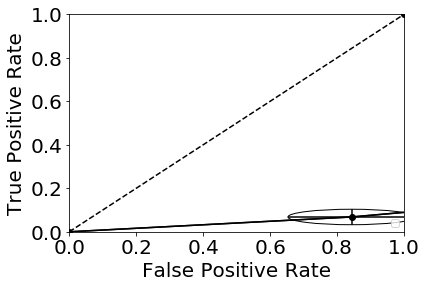

In [91]:
#add point (0,0)
FPR.append(0)
TPR.append(0)

#plot
fig, ax = plt.subplots()
plt.plot(FPR, TPR, 'ko-')
    
#set x and y limits, label plot
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate', size = 20)
plt.xlabel('False Positive Rate', size = 20)
ax.set_facecolor('white')
plt.tick_params(labelsize=20)


#error ellipses
ax.errorbar(FPR, TPR, xerr = x_errors, yerr = y_errors, color = 'k')

for i in range(10):
    ax.add_artist(Ellipse(xy = (FPR[i], TPR[i]), width = 2*x_errors[i], height = 2*y_errors[i], edgecolor = 'k', facecolor='none'))
plt.show() 

<h2> Area Under the Curve </h2>

In [96]:
print auc(FPR, TPR)

ValueError: Reordering is not turned on, and the x array is not increasing: [1.         6.83640119 6.83640119 6.83365393 6.83365393 6.80918324
 6.73326055 6.49397669 4.94545614 0.84346898 0.        ]